# ECOSTRESS View of Seattle, WA

From [AppEEARS](https://lpdaacsvc.cr.usgs.gov/appeears), I've downloaded a collection of geotiffs for ECOSTRESS LST for the more [urban counties](https://en.wikipedia.org/wiki/Seattle_metropolitan_area) on the east side of Puget Sound in Washington (Thurston, Pierce, King, and Snohomish counties; covering the Olympia-Tacoma-Seattle-Everett metro area)


Open one of our ECOSTRESS images, for Aug. 16, 2020 ([day of year](https://landweb.modaps.eosdis.nasa.gov/browse/calendar.html) 229), which was a record-breaking temperature day.
* https://www.seattleweatherblog.com/temperature-stats/
* https://twitter.com/NWSSeattle/status/1295171526677811201
* https://www.wunderground.com/calendar/us/wa/seattle/KSEA/date/2020-8

https://landsat.gsfc.nasa.gov/landsat-8/landsat-8-bands

In [1]:
import os
import xarray as xr
import rioxarray as rioxr
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box, mapping
import datetime as dt
from scipy.linalg import lstsq
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

#import warnings
#warnings.filterwarnings('ignore')

Load the Landsat 8 images

In [2]:
# Landsat 8 filepaths
l8_b1_filepath = '../sharpening/Seattle/CU_LC08.001_SRB1_doy2020236_aid0001.tif'
l8_b2_filepath = '../sharpening/Seattle/CU_LC08.001_SRB2_doy2020236_aid0001.tif'
l8_b3_filepath = '../sharpening/Seattle/CU_LC08.001_SRB3_doy2020236_aid0001.tif'
l8_b4_filepath = '../sharpening/Seattle/CU_LC08.001_SRB4_doy2020236_aid0001.tif'
l8_b5_filepath = '../sharpening/Seattle/CU_LC08.001_SRB5_doy2020236_aid0001.tif'
l8_b6_filepath = '../sharpening/Seattle/CU_LC08.001_SRB6_doy2020236_aid0001.tif'
l8_b7_filepath = '../sharpening/Seattle/CU_LC08.001_SRB7_doy2020236_aid0001.tif'

In [3]:
# Get band 2 reflectance (blue, 0.45-0.515 micron)
l8_b2 = xr.open_rasterio(l8_b2_filepath)
# Get band 3 reflectance (green, 0.533-0.590 micron)
l8_b3 = xr.open_rasterio(l8_b3_filepath)
# Get band 4 reflectance (red, 0.63-0.68 micron)
l8_b4 = xr.open_rasterio(l8_b4_filepath)
# Get band 5 reflectance (NIR, 0.845-0.885 micron)
l8_b5 = xr.open_rasterio(l8_b5_filepath)
# Get band 6 reflectance (SWIR, 1.560-1.660 micron)
l8_b6 = xr.open_rasterio(l8_b6_filepath)
# Get band 7 reflectance (SWIR2, 2.107-2.294 micron)
l8_b7 = xr.open_rasterio(l8_b7_filepath)


In [4]:
def cleanup_landsat_band(l8_band):
    # replace nodataval with nans
    l8_band = l8_band.where(l8_band.values != float(l8_band.attrs['nodatavals'][0]), np.nan)
    # scale refectance values
    l8_band.values = l8_band.values*float(l8_band.attrs['scale_factor'])
    # drop and remove the extra "band" dimension
    l8_band = l8_band.drop('band').squeeze()
    return l8_band

In [5]:
attrs_dict = l8_b2.attrs.copy()
_ = attrs_dict.pop('scale_factor')
attrs_dict['nodatavals'] = np.nan

In [6]:
l8 = xr.Dataset({'b2': cleanup_landsat_band(l8_b2),
                 'b3': cleanup_landsat_band(l8_b3),
                 'b4': cleanup_landsat_band(l8_b4),
                 'b5': cleanup_landsat_band(l8_b5),
                 'b6': cleanup_landsat_band(l8_b6),
                 'b7': cleanup_landsat_band(l8_b7)}, attrs=attrs_dict)

In [7]:
l8['ndvi'] = (l8.b5 - l8.b4) / (l8.b5 + l8.b4)
#l8['evi'] = 2.5 * ( (l8.b5 - l8.b4) / (l8.b5 + 6*l8.b4 - 7.5*l8.b2 + 1) ) # https://www.usgs.gov/core-science-systems/nli/landsat/landsat-enhanced-vegetation-index?qt-science_support_page_related_con=0#qt-science_support_page_related_con
#l8['ndwi'] = (l8.b5 - l8.b6) / (l8.b5 + l8.b6)
l8['mndwi'] = (l8.b3 - l8.b6) / (l8.b3 + l8.b6)
#l8['ndsi'] = (l8.b3 - l8.b6) / (l8.b3 + l8.b6)
l8['albedo'] = ((0.356*l8.b2) + (0.130*l8.b4) + (0.373*l8.b5) + (0.085*l8.b6) + (0.072*l8.b7) -0.0018) / 1.016

In [8]:
# set invalid NDVI to nan
l8['ndvi'] = l8.ndvi.where((l8.ndvi >= -1) | (l8.ndvi <= 1), np.nan)
# set invalid albedo to nan
l8['albedo'] = l8.albedo.where((l8.albedo >= 0) | (l8.albedo <= 1), np.nan)

In [9]:
# add CRS attributes

l8['ndvi'] = l8.ndvi.assign_attrs({'crs': l8.attrs['crs']})
#l8['evi'] = l8.evi.assign_attrs({'crs': l8.attrs['crs']})
#l8['ndwi'] = l8.ndwi.assign_attrs({'crs': l8.attrs['crs']})
l8['mndwi'] = l8.mndwi.assign_attrs({'crs': l8.attrs['crs']})
#l8['ndsi'] = l8.ndsi.assign_attrs({'crs': l8.attrs['crs']})
l8['albedo'] = l8.albedo.assign_attrs({'crs': l8.attrs['crs']})

Load the ECOSTRESS LST image

In [10]:
eco_lst_filepath = '../data/ECO2LSTE.001_SDS_LST_doy2020229172658_aid0001.tif'

In [11]:
eco_lst = xr.open_rasterio(eco_lst_filepath)

In [12]:
def cleanup_ecostress_lst(eco_lst):
    # replace nodataval with nans
    eco_lst = eco_lst.where(eco_lst.values != float(eco_lst.attrs['nodatavals'][0]), np.nan)
    # scale refectance values
    eco_lst.values = eco_lst.values*float(eco_lst.attrs['scale_factor'])
    # drop and remove the extra "band" dimension
    eco_lst = eco_lst.drop('band').squeeze()
    return eco_lst

In [13]:
eco_lst = cleanup_ecostress_lst(eco_lst)

In [14]:
# Coarsen Landsat 8 to ECOSTRESS resolution
l8_repr_match = l8.rio.reproject_match(eco_lst)

In [15]:
# remove water areas
eco_lst = eco_lst.where(l8_repr_match.mndwi < 0.5, np.nan)
l8_repr_match['ndvi'] = l8_repr_match.ndvi.where(l8_repr_match.mndwi < 0.5, np.nan)
l8_repr_match['albedo'] = l8_repr_match.albedo.where(l8_repr_match.mndwi < 0.5, np.nan)

Plot the coarse resolution, training datasets

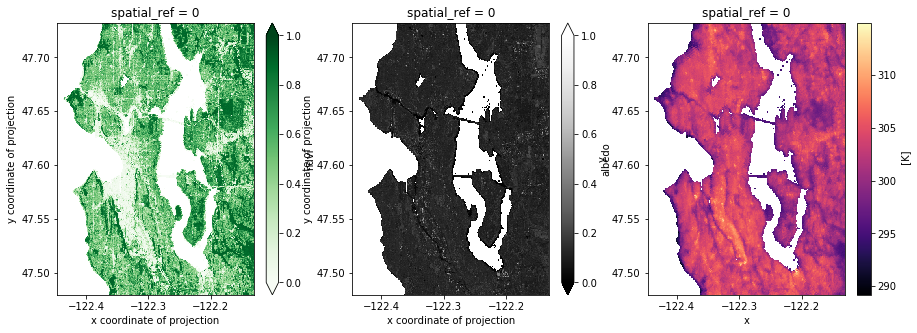

In [16]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

l8_repr_match.ndvi[900:1300,1200:1700].plot(cmap='Greens', vmin=0, vmax=1, ax=ax1)

l8_repr_match.albedo[900:1300,1200:1700].plot(cmap='Greys_r', vmin=0, vmax=1,  ax=ax2)

eco_lst[900:1300,1200:1700].plot(cmap='magma', ax=ax3)

**Set up and fit the model**

In [17]:
training_albedo = l8_repr_match.albedo[:,:2490].values.ravel()
training_ndvi = l8_repr_match.ndvi[:,:2490].values.ravel()
training_lst = eco_lst[:,:2490].values.ravel()

inrange = (training_albedo>=0) & (training_albedo<=1) & (training_ndvi>=-1) & (training_ndvi<=1)
training_albedo = training_albedo[inrange]
training_ndvi = training_ndvi[inrange]
training_lst = training_lst[inrange]

notnan = ~np.isnan(training_albedo) & ~np.isnan(training_ndvi) & ~np.isnan(training_lst)
training_albedo = training_albedo[notnan]
training_ndvi = training_ndvi[notnan]
training_lst = training_lst[notnan]

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less_equal
  """


Text(0, 0.5, 'LST')

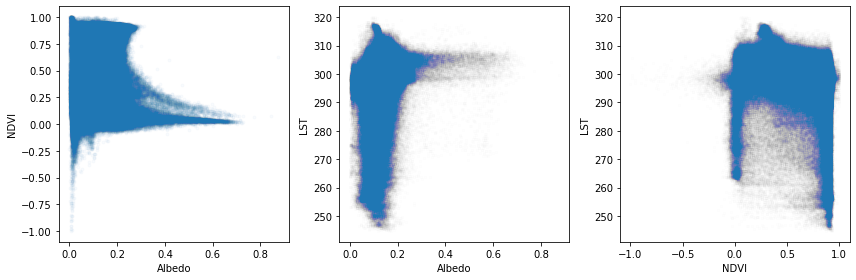

In [18]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3,figsize=(12,4), tight_layout=True)
ax1.plot(training_albedo.ravel(), training_ndvi.ravel(), '.', alpha=0.0-5);
ax1.set_xlabel('Albedo')
ax1.set_ylabel('NDVI')

ax2.plot(training_albedo.ravel(), training_lst.ravel(), '.', alpha=0.005);
ax2.set_xlabel('Albedo')
ax2.set_ylabel('LST')

ax3.plot(training_ndvi.ravel(), training_lst.ravel(), '.', alpha=0.005);
ax3.set_xlabel('NDVI')
ax3.set_ylabel('LST')

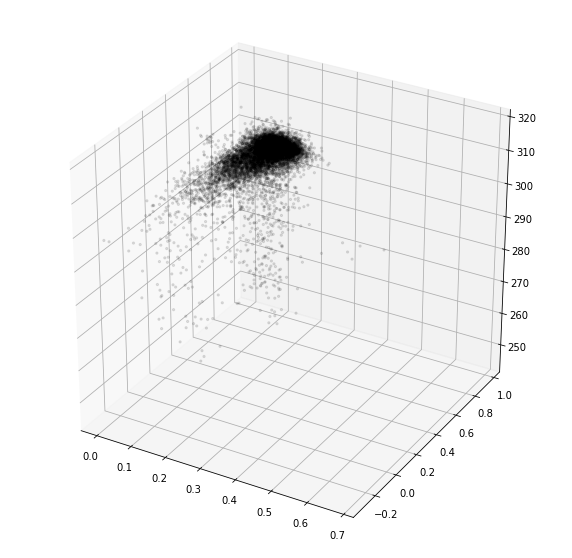

In [19]:
indices = np.random.randint(0,len(training_lst.ravel()), size=10000)

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(training_albedo.ravel()[indices], 
           training_ndvi.ravel()[indices],
           training_lst.ravel()[indices], 
           alpha=0.1, s=5, marker='o', c='k')

In [20]:
# create the input array
multi_input = np.array([np.ones_like(training_albedo), 
                        training_albedo, training_ndvi, 
                        training_albedo**2, training_ndvi**2,
                        training_ndvi*training_albedo,
                        training_albedo**3, training_ndvi**3,
                        training_ndvi*(training_albedo**2), (training_ndvi**2)*training_albedo,
                        training_albedo**4, training_ndvi**4,
                        training_ndvi*(training_albedo**3), (training_ndvi**3)*training_albedo
                       ]).T # Transform this array with ".T" to swap rows and columns


## create the input array
#multi_input = np.array([np.ones_like(albedo), 
#                        albedo, ndvi
#                       ]).T # Transform this array with ".T" to swap rows and columns
#
# Show the shapes of our two inputs to the lstsq function to make sure they have the same first dimension length
print(multi_input.shape)
print(training_lst.shape)

(3651614, 14)
(3651614,)


In [21]:
c, _, _, _ = lstsq(multi_input, training_lst)

In [22]:
c

array([ 292.00564215,   30.44282964,   11.79862281,  -32.97121886,
          8.73646565,  331.13704654,  -83.02778829,  -24.18998776,
       -210.62185387, -803.38936942,  147.11286414,   -2.764304  ,
       -142.01586776,  572.06955459])

Demo the model

In [23]:
albedo = np.random.rand(100,100)
ndvi = np.random.rand(100,100)*2-1

# apply model
fit_lst = c[0] + c[1]*albedo + c[2]*ndvi + c[3]*(albedo**2) + c[4]*(ndvi**2) + \
c[5]*ndvi*albedo +c[6]*(albedo**3) + c[7]*(ndvi**3) + c[8]*ndvi*(albedo**2) + \
c[9]*(ndvi**2)*albedo + c[10]*(albedo**4) + c[11]*(ndvi**4) + c[12]*ndvi*(albedo**3) + \
c[13]*(ndvi**3)*albedo 

(250, 320)

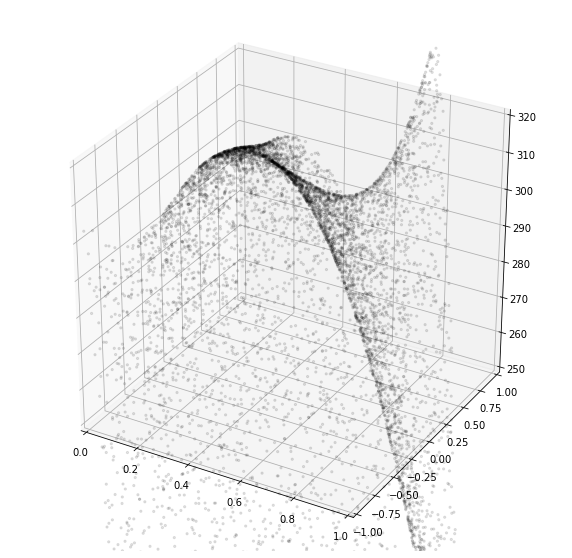

In [24]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(albedo.ravel(), 
           ndvi.ravel(),
           fit_lst.ravel(), 
           alpha=0.1, s=5, marker='o', c='k')
ax.set_xlim((0,1))
ax.set_ylim((-1,1))
ax.set_zlim((250,320))

**Low res fit** Apply the model

In [25]:
albedo = l8_repr_match.albedo
ndvi = l8_repr_match.ndvi

# apply model
fit_lst = c[0] + c[1]*albedo + c[2]*ndvi + c[3]*(albedo**2) + c[4]*(ndvi**2) + \
c[5]*ndvi*albedo +c[6]*(albedo**3) + c[7]*(ndvi**3) + c[8]*ndvi*(albedo**2) + \
c[9]*(ndvi**2)*albedo + c[10]*(albedo**4) + c[11]*(ndvi**4) + c[12]*ndvi*(albedo**3) + \
c[13]*(ndvi**3)*albedo 

(250, 320)

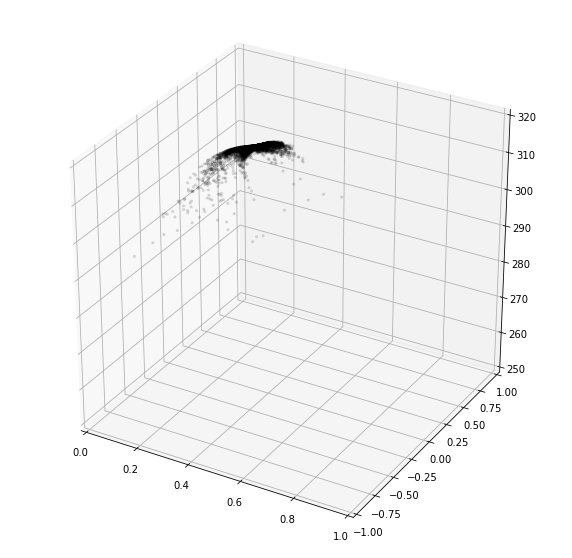

In [26]:
indices = np.random.randint(0,len(training_lst.ravel()), size=10000)

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(albedo.values.ravel()[indices], 
           ndvi.values.ravel()[indices],
           fit_lst.values.ravel()[indices], 
           alpha=0.1, s=5, marker='o', c='k')
ax.set_xlim((0,1))
ax.set_ylim((-1,1))
ax.set_zlim((250,320))

In [27]:
#fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3,figsize=(12,4))
#ax1.plot(albedo.values.ravel(), ndvi.values.ravel(), '.', alpha=0.1);
#ax2.plot(albedo.values.ravel(), fit_lst.values.ravel(), '.', alpha=0.1);
#ax3.plot(ndvi.values.ravel(), fit_lst.values.ravel(), '.', alpha=0.1);

In [28]:
# diff between observed and low res fit
lst_diff = eco_lst - fit_lst

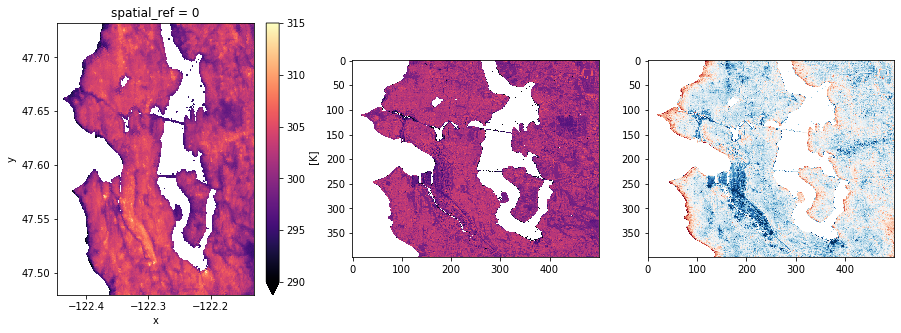

In [29]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

eco_lst[900:1300,1200:1700].plot(cmap='magma', ax=ax1, vmin=290, vmax=315)

ax2.imshow(fit_lst[900:1300,1200:1700], cmap='magma', vmin=290, vmax=315)

ax3.imshow(lst_diff[900:1300,1200:1700], cmap='RdBu', vmin=-10, vmax=10)

**Smoothing** (NOTE: this is a crucial step and needs to be performed to get accurate results) 

Building matrices that will compute running sums. The ler-matrix, eL, smooths along the rows. The right-matrix, eR, smooths along the columns. You end up replacing element "i" by the mean of a (2*Nr+1)-by- (2*Nc+1) rectangle centered on element "i".

In [30]:
# Setting all "NaN" elements of "matrixIn" to zero so that these will not
# affect the summation. (If this isn't done, any sum that includes a NaN
# will also become NaN.) 
lst_diff_da =  xr.DataArray(lst_diff)#.fillna(0)

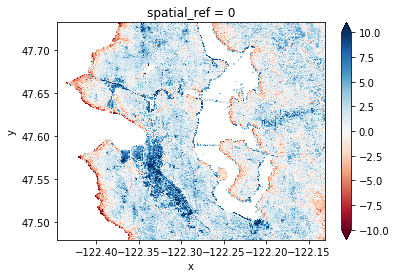

In [31]:
lst_diff_da[900:1300,1200:1700].plot(cmap='RdBu', vmin=-10, vmax=10)

In [32]:
lst_diff_da_smoothed = lst_diff_da.rolling(x=2).mean().rolling(y=2).mean()

In [33]:
lst_diff_da_smoothed = lst_diff_da_smoothed.assign_attrs(eco_lst.attrs)

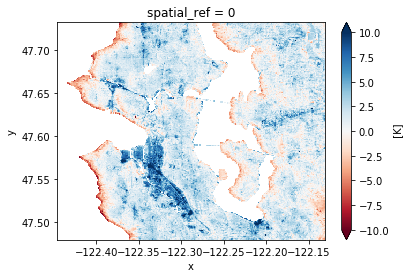

In [34]:
lst_diff_da_smoothed[900:1300,1200:1700].plot(cmap='RdBu', vmin=-10, vmax=10)

In [35]:
#matrixIn = tdiff;
#N(1) = 2; 
#N(2) = 2; # Smooth over 2x2 pixels
#[row,col] = size(matrixIn);
#
#eL = spdiags( ones(row,2*N(1)+1),(-N(1):N(1)),row,row);
#eR = spdiags (ones(col,2*N(2)+1),(-N(2):N(2)),col,col); 


In [36]:
#
#
#%%
#% For each element, we have to count how many non-NaN elements went into
#% the sums. This is so we can divide by that number to get a mean. We use
#% the same matrices to do this (ie, "eL" and "eR"). 
#
#nrmlize = eL*(~A)*eR;
#nrmlize(A) = NaN;
#matrixOut = eL*double(matrixIn)*eR; % matrixIn needs to be a double here
#matrixOut = matrixOut./nrmlize;
#tdiff = matrixOut; 
#
#

In [37]:
#%% high res sharpening LST fit
#fi72 = xt(1) + xt(2).*Albedo + xt(3).*NDVI + xt(4).*Albedo.^2 + xt(5).*NDVI.^2 + xt(6).*NDVI.*Albedo + ...
#xt(7).*Albedo.^3 + xt(8).*NDVI.^3 + xt(9).*NDVI.*Albedo.^2 +xt(10).*NDVI.^2.*Albedo + ...
#xt(11).*Albedo.^4 + xt(12).*NDVI.^4 + xt(13).*NDVI.*Albedo.^3 + xt(14).*NDVI.^3.*Albedo;
#
#tdiff2 = imresize(tdiff,size(fi72),'nearest'); 
#

#
#
#
#%% Write out the final image to a new file
#geotiffwrite('LST_sharp_1.tif',LSTsharp,sr2R);

**High res fit**

In [38]:
albedo = l8.albedo.where((l8.albedo>=0) & (l8.albedo<=1))[2200:3200,2900:4000].values
ndvi = l8.ndvi.where((l8.ndvi>=-1) & (l8.ndvi<=1))[2200:3200,2900:4000].values

# apply model
fit_lst = c[0] + c[1]*albedo + c[2]*ndvi + c[3]*(albedo**2) + c[4]*(ndvi**2) + \
c[5]*ndvi*albedo +c[6]*(albedo**3) + c[7]*(ndvi**3) + c[8]*ndvi*(albedo**2) + \
c[9]*(ndvi**2)*albedo + c[10]*(albedo**4) + c[11]*(ndvi**4) + c[12]*ndvi*(albedo**3) + \
c[13]*(ndvi**3)*albedo 

In [39]:
lst_diff_high_res = lst_diff_da_smoothed.rio.reproject_match(l8.albedo)

In [40]:
# Final 30m sharpened LST
LSTsharp = fit_lst + lst_diff_high_res[2200:3200,2900:4000]

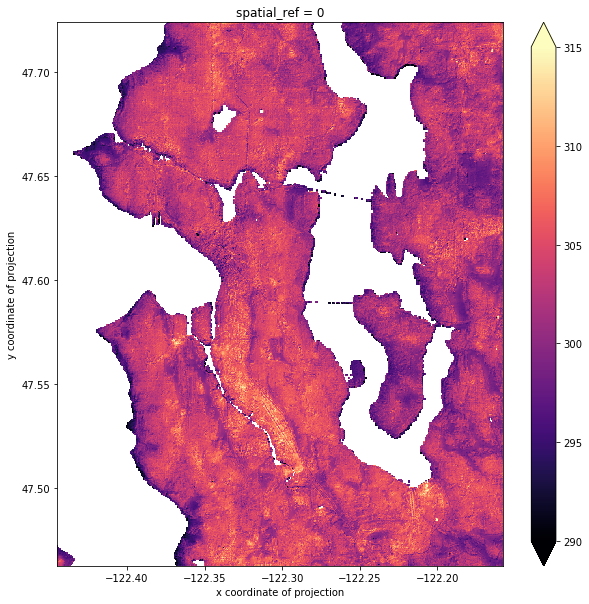

In [41]:
LSTsharp.plot(cmap='magma', vmin=290, vmax=315, figsize=(10,10))

In [42]:
LSTsharp.to_netcdf('LST_sharp_test_4.nc')

---

In [43]:
eco_lst_repr_match = eco_lst.rio.reproject_match(l8.b2)

In [44]:
# diff between observed and high res fit
lst_high_res_eco_diff = eco_lst_repr_match[2200:3200,2900:4000] - fit_lst

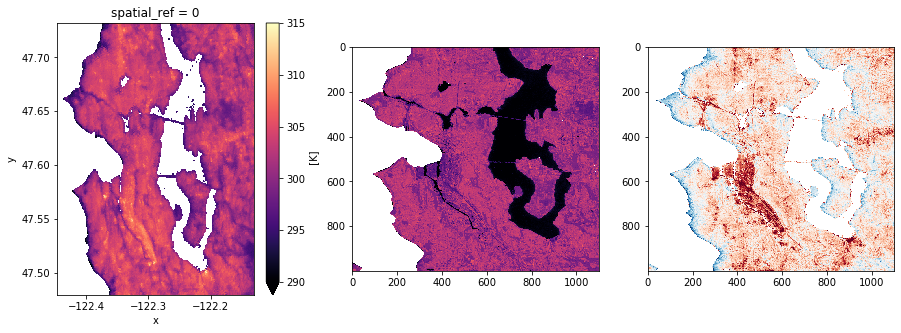

In [45]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

eco_lst[900:1300,1200:1700].plot(cmap='magma', ax=ax1, vmin=290, vmax=315)

ax2.imshow(fit_lst, cmap='magma', vmin=290, vmax=315)

ax3.imshow(lst_high_res_eco_diff, cmap='RdBu_r', vmin=-10, vmax=10)

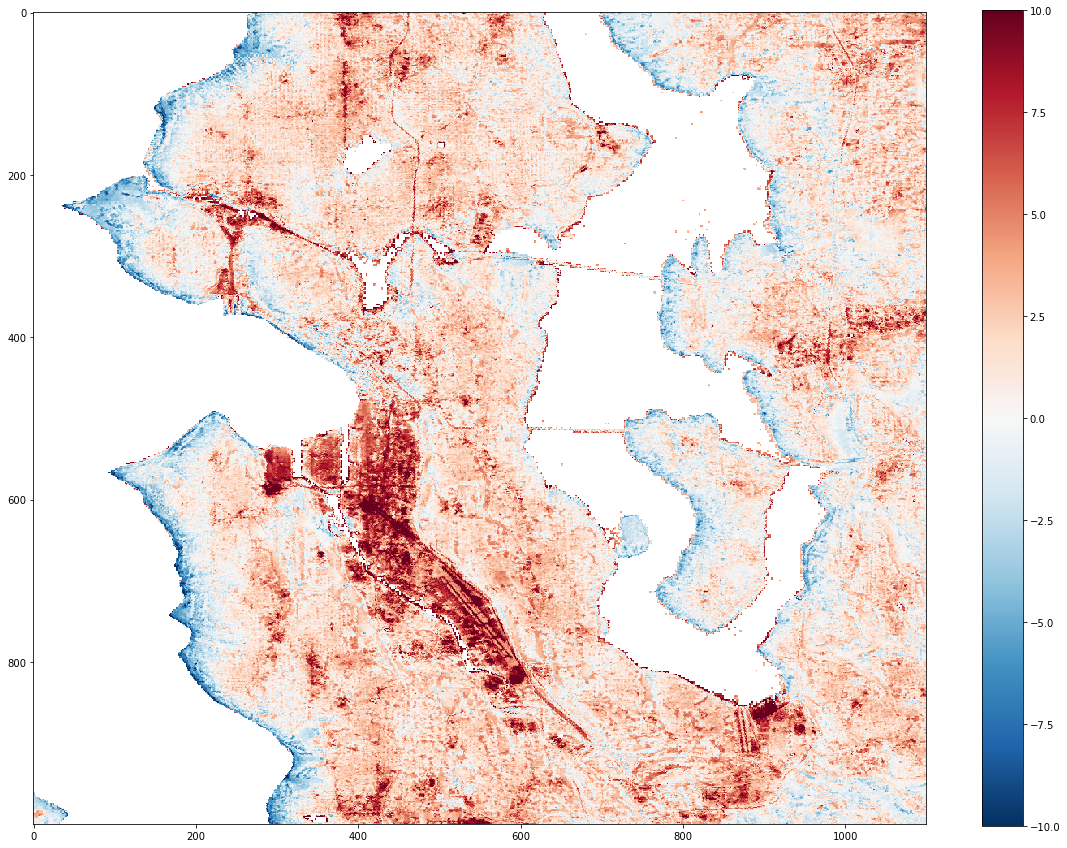

In [46]:
plt.figure(figsize=(20,15))
plt.imshow(lst_high_res_eco_diff, cmap='RdBu_r', vmin=-10, vmax=10)
plt.colorbar();

---

Plot our ECOSTRESS image and Seattle neighborhoods

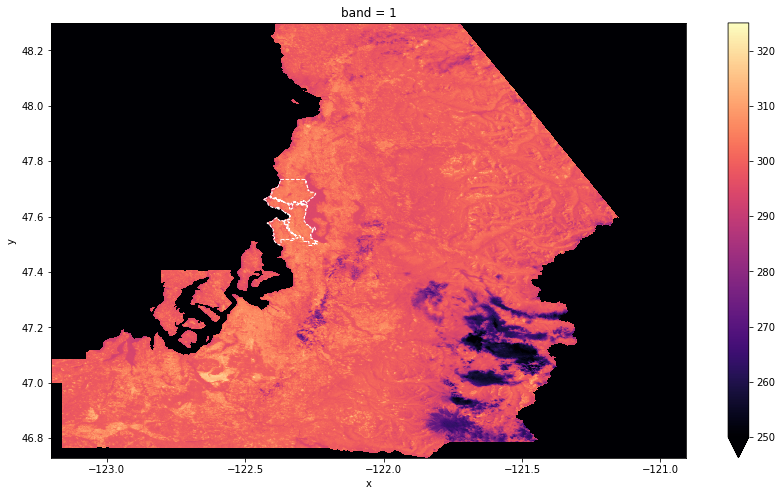

In [13]:
fig, ax = plt.subplots(figsize=(15,8))

scaled_eco_lst.plot(x='x', y='y', ax=ax, vmin=250, vmax=325, cmap='magma')

seattle_all.plot(ax=ax, edgecolor='white', linestyle='--', facecolor='none');

ax.set_aspect(1)

---

Now let's look at the neighborhood level.

In [14]:
# Aaggregate by the larger neighborhood boundaries:
seattle = seattle.dissolve(by='L_HOOD', aggfunc='sum')

Mask using the neighborhoods shapefile

In [15]:
seattle_all_lst = eco_lst.rio.clip(seattle_all.geometry.apply(mapping),crs=seattle_all.crs)

# switch our zero values to nan values
seattle_all_lst = seattle_all_lst.where(seattle_all_lst > 0)

Scale our clipped dataset and convert from Kelvin to Celsius

In [16]:
# scale our clipped dataset and convert from K to C
scaled_seattle_lst = ( seattle_all_lst * float(eco_lst.attrs['scale_factor']) ) - 273.15

Compute some zonal statistics

In [17]:
# Compute zonal statistics
# Remove NaN pixel values
values = scaled_seattle_lst.values.flatten()
values = values[~np.isnan(values)]

# Print zonal statistics
summary_stats = 'Temperature Histogram\nMean: {}, Median: {}\nMax: {}, Min: {}, Standard Deviation: {}' \
                .format(np.round(values.mean(),1),
                np.round(np.median(values),1),
                np.round(values.max(),1),
                np.round(values.min(),1),
                np.round(values.std(),1))

print(summary_stats)

Temperature Histogram
Mean: 30.0, Median: 30.5
Max: 41.2, Min: 16.9, Standard Deviation: 2.5


Plot the clipped ECOSTRESS image and histogram with summary statistics

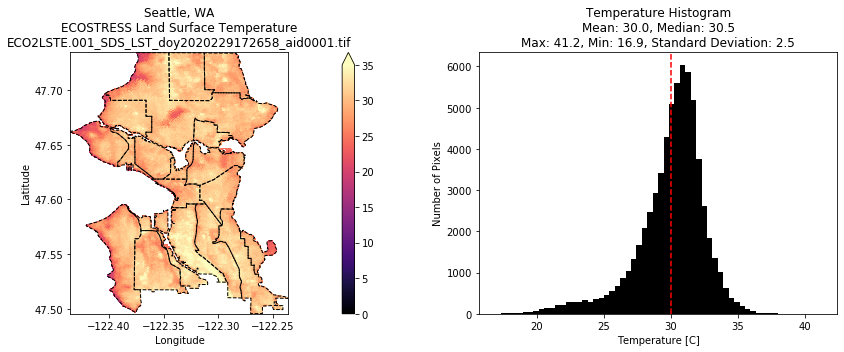

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,5), gridspec_kw={'width_ratios': [3, 1]})

# image
scaled_seattle_lst.plot(x='x', y='y', ax=ax1, vmin=0, vmax=35, cmap='magma')
seattle.plot(ax=ax1, edgecolor='black', linestyle='--', facecolor='none');
ax1.set_ylabel('Latitude')
ax1.set_xlabel('Longitude')
ax1.set_title('Seattle, WA\nECOSTRESS Land Surface Temperature\n{}'.format(file_list.filename[i]))
ax1.set_aspect(1)

# histogram
ax2.hist(values, bins=60, facecolor='k');
ax2.axvline(x=values.mean(), c='r', linestyle='--')
ax2.set_title(summary_stats)
ax2.set_ylabel('Number of Pixels')
ax2.set_xlabel('Temperature [C]')

plt.tight_layout()

---

Now loop through and look at each neighborhood individually:

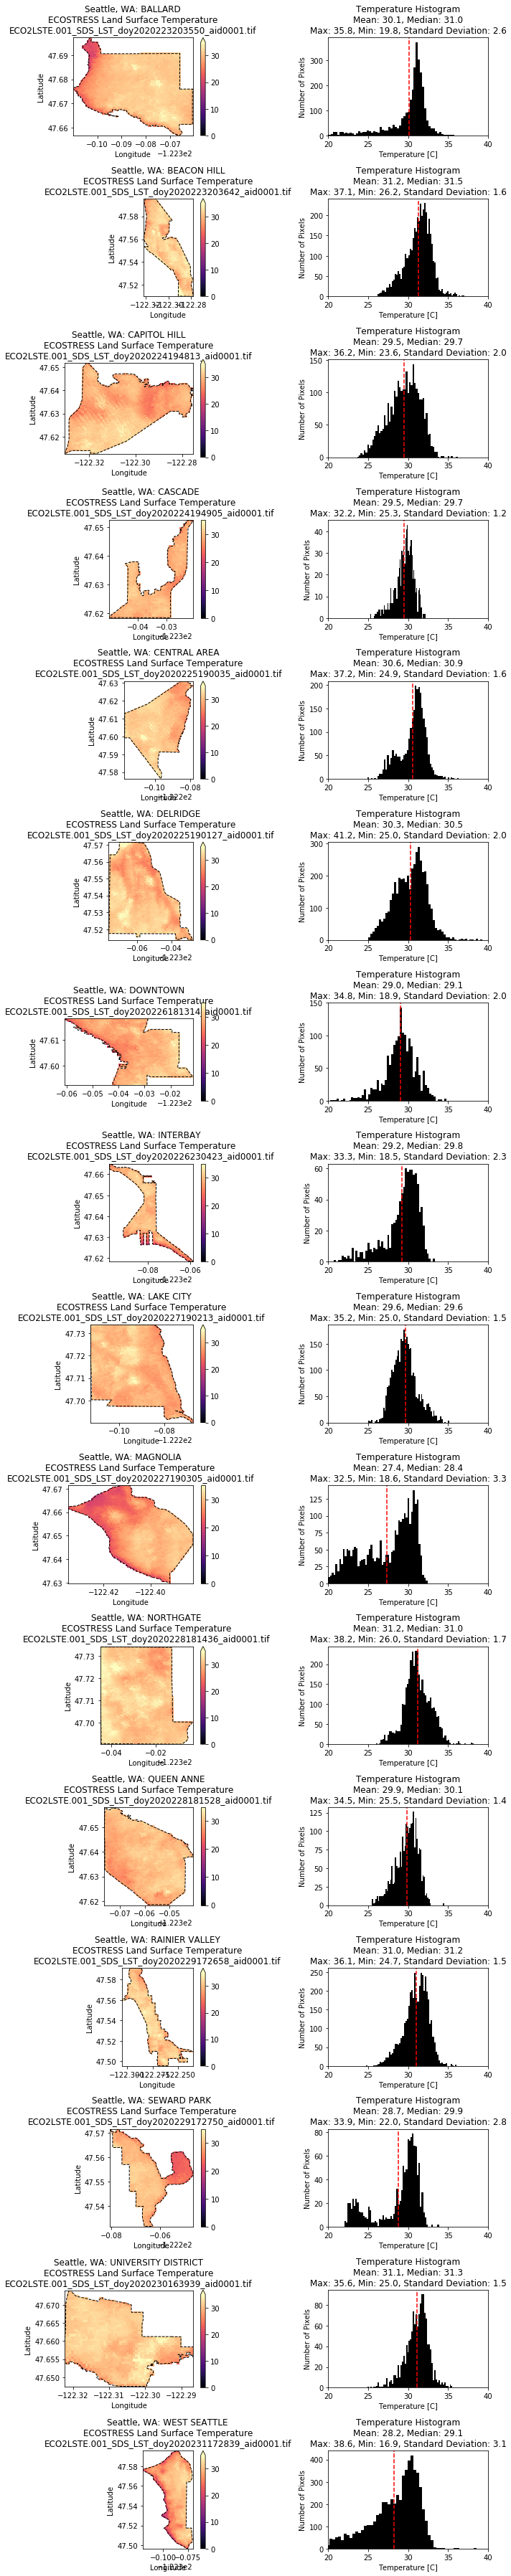

In [19]:
# Set up the plot for clipped ECOSTRESS images and histograms with summary statistics
fig, ax = plt.subplots(nrows=16, ncols=2, figsize=(10,50))

# counter for plots
i = 0
for index, neighborhood in seattle.iterrows():
    # skip areas not in a designated neighborhood
    if neighborhood.name != 'NO BROADER TERM':
        
        
        # Mask using the neighborhood geometry
        neighborhood_geom = gpd.GeoSeries(neighborhood.geometry) # we need this as a geoseries
        this_neighborhood_lst = eco_lst.rio.clip(neighborhood_geom.apply(mapping),crs=seattle.crs)
    
        # Switch our zero values to nan values
        this_neighborhood_lst = this_neighborhood_lst.where(this_neighborhood_lst > 0)
        
        # Scale our clipped dataset and convert from Kelvin to Celsius
        this_neighborhood_lst = ( this_neighborhood_lst * float(eco_lst.attrs['scale_factor']) ) - 273.15
        
        # Compute some zonal statistics
        # Remove NaN pixel values
        values = this_neighborhood_lst.values.flatten()
        values = values[~np.isnan(values)]
        
        # Print zonal statistics
        summary_stats = 'Temperature Histogram\nMean: {}, Median: {}\nMax: {}, Min: {}, Standard Deviation: {}' \
                        .format(np.round(values.mean(),1),
                        np.round(np.median(values),1),
                        np.round(values.max(),1),
                        np.round(values.min(),1),
                        np.round(values.std(),1))
    
        # image
        this_neighborhood_lst.plot(x='x', y='y', ax=ax[i,0], vmin=0, vmax=35, cmap='magma')
        neighborhood_geom.plot(ax=ax[i,0], edgecolor='black', linestyle='--', facecolor='none');
        ax[i,0].set_ylabel('Latitude')
        ax[i,0].set_xlabel('Longitude')
        ax[i,0].set_title('Seattle, WA: {}\nECOSTRESS Land Surface Temperature\n{}'.format(neighborhood.name, file_list.filename[i]))
        ax[i,0].set_aspect(1)
        
        # histogram
        ax[i,1].hist(values, bins=60, facecolor='k');
        ax[i,1].axvline(x=values.mean(), c='r', linestyle='--')
        ax[i,1].set_title(summary_stats)
        ax[i,1].set_ylabel('Number of Pixels')
        ax[i,1].set_xlabel('Temperature [C]')
        ax[i,1].set_xlim((20,40))
        
        plt.tight_layout()
        i+=1